In [1]:
%matplotlib inline

In [2]:
import os
import copy

from time import time, strftime, gmtime

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from imgaug import augmenters as iaa
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
path_train = 'img_dataset/train'
path_test = 'img_dataset/test'

In [4]:
np.random.seed(1337)
torch.manual_seed(1337)

In [5]:
def make_train_set(folder_name_=None):
    if folder_name_ is None:
        return
    resize_w = 320
    resize_h = 320
    path_folder = f'{BASE_DIR}/img_dataset_base_size/{folder_name_}'
    path_folder_resize = f'{BASE_DIR}/img_dataset/train/{folder_name_.split("_")[0]}'
    os_listdir = os.listdir(path_folder)

    # Augmentations settings
    augmentation = True if len(os_listdir) < 1000 else False

    seq = iaa.Sequential([
        iaa.Affine(rotate=(-25, 25)),
        iaa.AdditiveGaussianNoise(scale=(10, 45)),
        # iaa.AddToHueAndSaturation((-60, 60)),  # change their color
        # iaa.ElasticTransformation(alpha=90, sigma=9),  # water-like effect
    ])

    # print(len(os_listdir))


    for filename in os_listdir:
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            print('обрабатываем')
            raw_img = Image.open(f'{path_folder}/{filename}').convert('RGB')
            print(raw_img.size)
            resize_image = raw_img.resize((resize_w, resize_h))
            if not os.path.exists(path_folder_resize):
                os.makedirs(path_folder_resize, exist_ok=True)
            if augmentation:
                img_np = np.asarray(resize_image)
                img_aug = [copy.copy(img_np) for el in range(2)]
                img_aug = seq(images=img_aug)
                img_aug = [Image.fromarray(np.uint8(el)) for el in img_aug]
                for el in img_aug:
                    el.save(f'{path_folder_resize}/{resize_w}_{resize_h}_{img_aug.index(el)}_{filename}')
                img_aug.clear()
            resize_image.save(f'{path_folder_resize}/{resize_w}_{resize_h}_{filename}')
            print(resize_image.size)
        else:
            print(f'{filename} [skip]')

# Установить True, если необходимо подготовить тренировочный набор данных
resize_set = False

if resize_set:
    folder_names_list = ['jaguar_train', 'lion_train', 'panther_train']
    for folder_name in folder_names_list:
        make_train_set(folder_name)

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_dataset = torchvision.datasets.ImageFolder(
    root=f'{BASE_DIR}/{path_train}',
    transform=train_transform
)

test_dataset = torchvision.datasets.ImageFolder(
    root=f'{BASE_DIR}/{path_test}',
    transform=test_transform
)

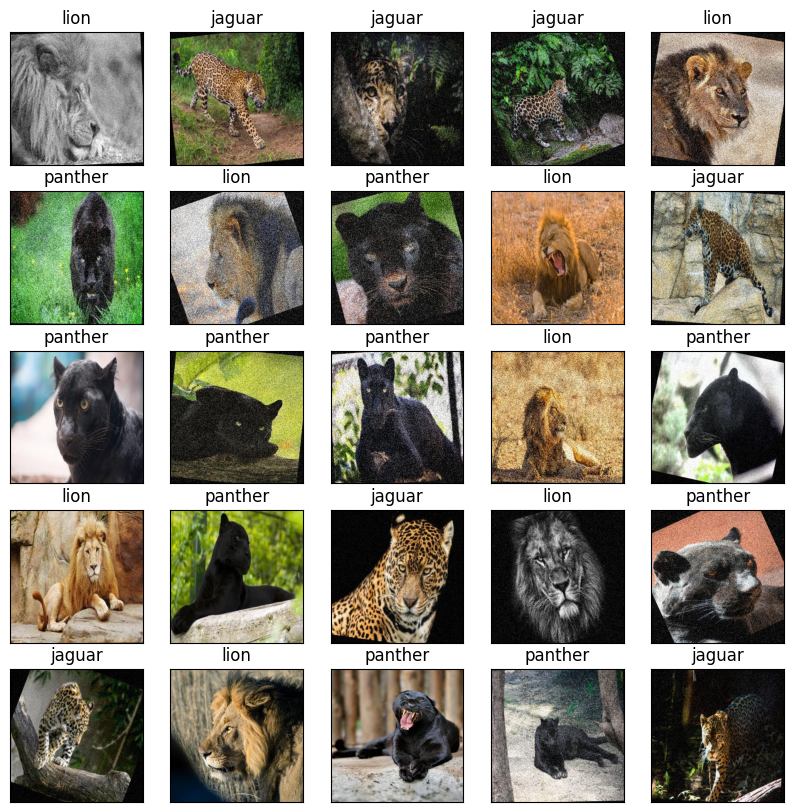

In [8]:
fig = plt.figure(figsize=(10, 10))
rows, columns = 5, 5
visualize_dataset = torchvision.datasets.ImageFolder(root=f'{BASE_DIR}/{path_train}')
# rand_indeces = np.random.randint(low=0, high=len(visualize_dataset), size=(rows*columns,))
rand_indeces = np.random.randint(low=0, high=len(train_dataset), size=(rows*columns,))
images = []
labels = []

for i in rand_indeces:
    img, class_ = visualize_dataset[i]
    images.append(img)
    labels.append(visualize_dataset.classes[class_])

# visualize these random images
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{labels[i-1]}")

In [9]:
# Number of classes in the dataset
num_classes = len(train_dataset.classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 50

# Number of epochs to train for
num_epochs = 15 #15

# Device for running training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time()

    train_acc_history = []
    train_loss_history = []

    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    y_pred_proba = torch.softmax(outputs, dim=1)
                    y_pred = y_pred_proba.argmax(dim=1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(y_pred == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            torch.save(model, f"e{epoch}_course_model_p{phase}_l{epoch_loss:.4f}_a{epoch_acc:.4f}.pth")

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [11]:
# Create training and validation datasets

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Create training and validation dataloaders
dataloaders_dict = {
    "train": train_dataloader,
    "val": test_dataloader,
}

In [ ]:

def time_counter(func):
    def wrapper(*args, **kwargs):
        ts = time()
        result = func(*args, **kwargs)
        te = time()
        delta = te - ts
        print(f'Время выполнения: {strftime("%H:%M:%S", gmtime(delta))}')
        return result
    return wrapper


def print_metrics_scores(scores: dict) -> None:
    print(f'confusion_matrix: \n{scores.get("confusion_matrix")}')
    print(f'classification_report: \n{scores.get("classification_report")}')


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, 3, 1)             # 3*3*3*50+50 = 1400
        self.conv2 = nn.Conv2d(50, 20, 3, 1)            # 3*3*50*20+20 = 9020
        self.conv3 = nn.Conv2d(20, 8, 3, 1)            # 3*3*20*8+8 = 1448
        self.dropout1 = nn.Dropout(0.25)                # <- 0
        self.dropout2 = nn.Dropout(0.5)                 # <- 0
        self.fc1 = nn.Linear(23328, 128)                  # <- 23328*128+128 = 2986112
        self.fc2 = nn.Linear(128, 3)                   # <- 128*3+3 = 387
        self.batch_norm = torch.nn.BatchNorm1d(23328)     # <- 23328*2 = 46656
                                                        # Total: 3045023
    def forward(self, x):           # 50, 3, 224, 224
        x = self.conv1(x)           # 50, 50, 222, 222
        x = F.relu(x)               # 50, 50, 222, 222
        x = self.conv2(x)           # 50, 20, 220, 220
        x = F.relu(x)               # 50, 20, 220, 220
        x = F.max_pool2d(x, 2)      # 50, 20, 110, 110
        x = self.conv3(x)           # 50, 8, 108, 108
        x = F.relu(x)               # 50, 8, 108, 108
        x = F.max_pool2d(x, 2)      # 50, 8, 54, 54
        x = self.dropout1(x)        # 50, 8, 54, 54
        x = torch.flatten(x, 1)     # 50, 8*54*54 = 23328
        x = self.batch_norm(x)      # 50, 23328
        x = self.fc1(x)             # 50, 128
        x = F.relu(x)               # 50, 128
        x = self.dropout2(x)        # 50, 128
        output = self.fc2(x)        # 50, 3
        return output


def model_train(model, device, train_loader, optimizer, epoch, loss_fn):
    train_loss = 0
    correct = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)
    train_accuracy = correct / len(train_loader.dataset)
    train_accuracy_list.append(train_accuracy)


def model_test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    all_target = []
    all_pred = []
    classification_metrics_dict = {}
    with torch.no_grad():
        for batch_idx_, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += loss_fn(output, target).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_target = [*all_target, *target.tolist()]
            all_pred = [*all_pred, *pred.tolist()]
            if batch_idx_ == len(test_loader) - 1:
                target_names = ['cls 0', 'cls 1', 'cls 2']
                all_target = torch.Tensor(all_target)
                all_pred = torch.Tensor(all_pred)
                classification_metrics_dict.update({
                    'confusion_matrix': confusion_matrix(all_target, all_pred),
                    'classification_report': classification_report(all_target, all_pred, target_names=target_names)
                })
                print_metrics_scores(classification_metrics_dict)
                disp = ConfusionMatrixDisplay(
                    confusion_matrix=classification_metrics_dict['confusion_matrix'],
                    display_labels=target_names
                )
                disp.plot()
                plt.savefig(f"Confusion_matrix.png")
                plt.close()

    test_loss /= len(test_loader.dataset)
    test_loss_list.append(test_loss)
    test_accuracy = correct / len(test_loader.dataset)
    test_accuracy_list.append(test_accuracy)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_accuracy))


@time_counter
def main():

    torch.manual_seed(1337)

    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    print(device)

    batch_size_ds = 50

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_ds, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_ds, shuffle=False)

    epochs = 5 # 15

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    loss_fn = torch.nn.CrossEntropyLoss()

    scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
    for epoch in range(epochs):
        model_train(model, device, train_loader, optimizer, epoch, loss_fn)
        model_test(model, device, test_loader, loss_fn)
        scheduler.step()

    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(model)
    print(summary(model, input_size=(3, 224, 224)))


def plot_curve(title_: str, xlabel_: str, ylabel_: str,
               curve_list_1: list, curve_list_2: list, curve_label_1: str,
               curve_label_2: str, file_name: str) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.title(f'{title_}')
    plt.xlabel(f'{xlabel_}')
    plt.ylabel(f'{ylabel_}')
    ax.plot(np.arange(0, len(curve_list_1), 1), curve_list_1, "o-", label=curve_label_1)
    ax.plot(np.arange(0, len(curve_list_2), 1), curve_list_2, "o-", label=curve_label_2)
    ax.legend(loc="best")

    plt.savefig(f"{file_name}")
    plt.close()


if __name__ == '__main__':
    # Init lists
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []

    main()

    # Plot results
    plot_curve('Loss function', 'Samples', 'Loss',
               train_loss_list, test_loss_list,
               "Train loss", "Test loss", "Loss.png")
    plot_curve('Loss function', 'Samples', 'Loss',
               train_loss_list, test_loss_list,
               "Log train loss", "Log test loss", "Loss_log.png")
    plot_curve('Accuracy curve', 'Epoch', 'Accuracy',
               train_accuracy_list, test_accuracy_list,
               "Train", "Test", "Accuracy curve.png")


In [13]:
from torchvision.models import ResNet18_Weights

# Number of classes in the dataset
num_classes = len(train_dataset.classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 1000

# Number of epochs to train for
num_epochs = 14

# Device for running training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_r_18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Training only the last layer, the other layers are freezed
for param in model_r_18.parameters():
    param.requires_grad = False

num_ftrs = model_r_18.fc.in_features
model_r_18.fc = nn.Linear(num_ftrs, num_classes)
print(f"{num_ftrs = }")

num_ftrs = 512


In [42]:
# Send the model to GPU
model_r_18 = model_r_18.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params=model_r_18.parameters())

In [43]:
print(summary(model_r_18, input_size=(3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [14]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model_r_18, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

NameError: name 'optimizer_ft' is not defined

In [45]:
val_acc_history_cpu = [i.item() for i in val_acc_history]
val_loss_history_cpu = val_loss_history
train_acc_history_cpu = [i.item() for i in train_acc_history]
train_loss_history_cpu = train_loss_history

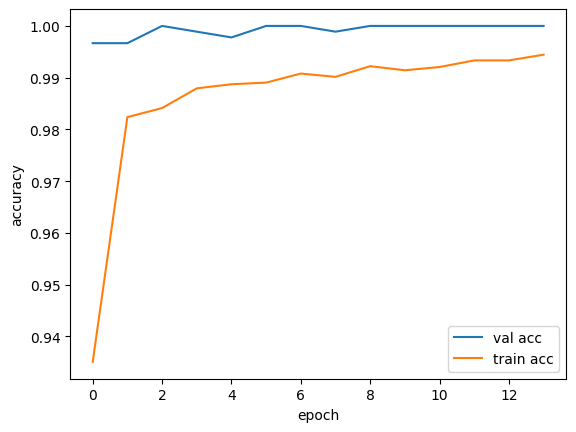

In [46]:
plt.plot(val_acc_history_cpu, label="val acc")
plt.plot(train_acc_history_cpu, label="train acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

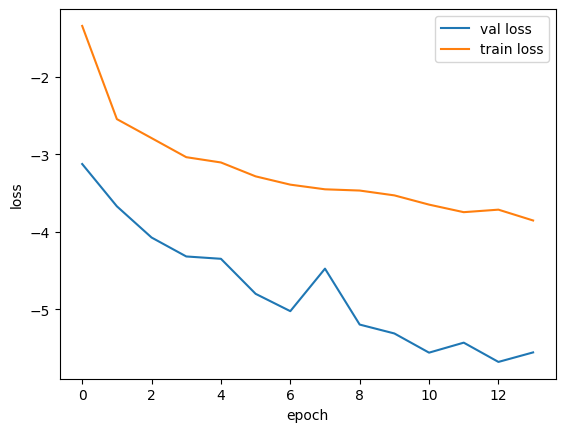

In [47]:
plt.plot(np.log(np.array(val_loss_history_cpu)), label="val loss")
plt.plot(np.log(np.array(train_loss_history_cpu)), label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [13]:
from torchvision.models import ResNet101_Weights

# Number of classes in the dataset
num_classes = len(train_dataset.classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 1000

# Number of epochs to train for
num_epochs = 14

# Device for running training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_r_101 = models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)

# Training only the last layer, the other layers are freezed
for param in model_r_101.parameters():
    param.requires_grad = False

num_ftrs = model_r_101.fc.in_features
model_r_101.fc = nn.Linear(num_ftrs, num_classes)
print(f"{num_ftrs = }")

num_ftrs = 2048


In [14]:
# Send the model to GPU
model_r_101 = model_r_101.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params=model_r_101.parameters())

In [15]:
print(summary(model_r_101, input_size=(3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [16]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model_r_101, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/13
----------
train Loss: 0.1670 Acc: 0.9605
val Loss: 0.0204 Acc: 0.9989

Epoch 1/13
----------
train Loss: 0.0474 Acc: 0.9892
val Loss: 0.0125 Acc: 1.0000

Epoch 2/13
----------
train Loss: 0.0323 Acc: 0.9924
val Loss: 0.0078 Acc: 1.0000

Epoch 3/13
----------
train Loss: 0.0277 Acc: 0.9927
val Loss: 0.0043 Acc: 1.0000

Epoch 4/13
----------
train Loss: 0.0314 Acc: 0.9894
val Loss: 0.0031 Acc: 1.0000

Epoch 5/13
----------
train Loss: 0.0196 Acc: 0.9949
val Loss: 0.0025 Acc: 1.0000

Epoch 6/13
----------
train Loss: 0.0226 Acc: 0.9938
val Loss: 0.0037 Acc: 1.0000

Epoch 7/13
----------
train Loss: 0.0186 Acc: 0.9951
val Loss: 0.0028 Acc: 1.0000

Epoch 8/13
----------
train Loss: 0.0191 Acc: 0.9943
val Loss: 0.0017 Acc: 1.0000

Epoch 9/13
----------
train Loss: 0.0160 Acc: 0.9952
val Loss: 0.0026 Acc: 1.0000

Epoch 10/13
----------
train Loss: 0.0155 Acc: 0.9959
val Loss: 0.0012 Acc: 1.0000

Epoch 11/13
----------
train Loss: 0.0150 Acc: 0.9957
val Loss: 0.0012 Acc: 1.0000

Ep

In [17]:
val_acc_history_cpu = [i.item() for i in val_acc_history]
val_loss_history_cpu = val_loss_history
train_acc_history_cpu = [i.item() for i in train_acc_history]
train_loss_history_cpu = train_loss_history

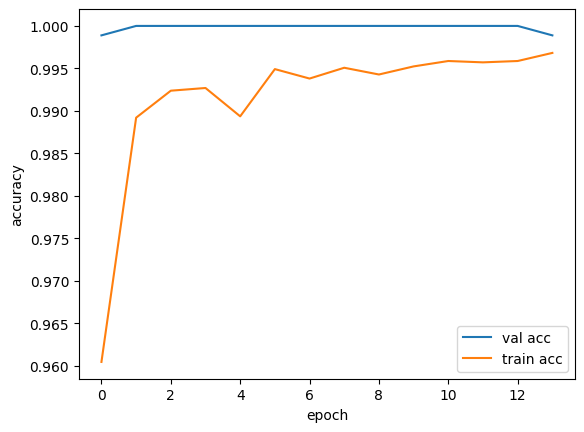

In [18]:
plt.plot(val_acc_history_cpu, label="val acc")
plt.plot(train_acc_history_cpu, label="train acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

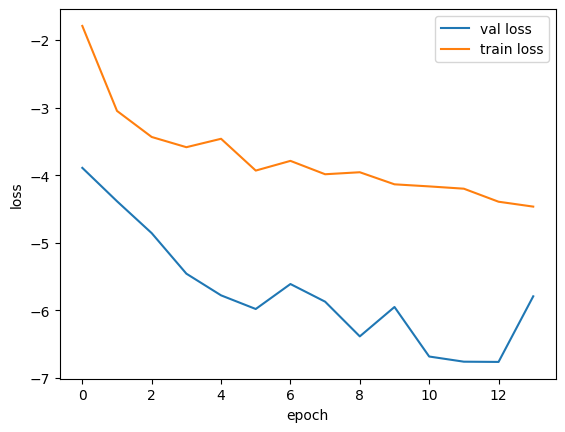

In [19]:
plt.plot(np.log(np.array(val_loss_history_cpu)), label="val loss")
plt.plot(np.log(np.array(train_loss_history_cpu)), label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()